# Generating Spectrograms

Now we'll be generating spectrograms for each audio  file. We'll be passing this spectrogram image into a CNN in the next worksheet, which will then classify the audio based on the content of this output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import glob
import random


from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split



from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa


import librosa
import librosa.display

from scipy.stats import skew

## Librosa Spectrogram Call

We'll use the two functions below to generate the Mel Spectrograms from our audio data. This code heavily utilizes the work of Jeff Prosise, who had previously created a similar workflow for his project to classify audio in the Amazon Rainforest. A reference to his project can be found at #11 in my references list.

Once again, we'll be using the Librosa library to generate this data from the audio files in our dataset.

In [3]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    mel_spec = librosa.feature.melspectrogram(y, sr=sr)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(log_mel, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    processed_files = set()

    for root, dirs, files in os.walk(input_path):
        for file in files:
            if file.endswith('.wav'):
                input_file = os.path.join(root, file)
                output_file = os.path.join(output_path, file.strip('.wav') + '.png')
                if input_file not in processed_files and not os.path.exists(output_file):
                    create_spectrogram(input_file, output_file)
                    processed_files.add(input_file)

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_12303/2799869948.py:7: FutureWarning: Pass y=[0.1291421  0.13189252 0.0618784  ... 0.07452936 0.09005939 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, sr=sr)
/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_12303/2799869948.py:7: FutureWarning: Pass y=[-0.03996851 -0.04599679 -0.03693829 ...  0.06817569  0.08307176
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, sr=sr)
/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_12303/2799869948.py:7: FutureWarning: Pass y=[-0.03016205  0.01949517  0.01798468 ... -0.04546496  0.05766832
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, sr=sr)
/var/

KeyboardInterrupt: 

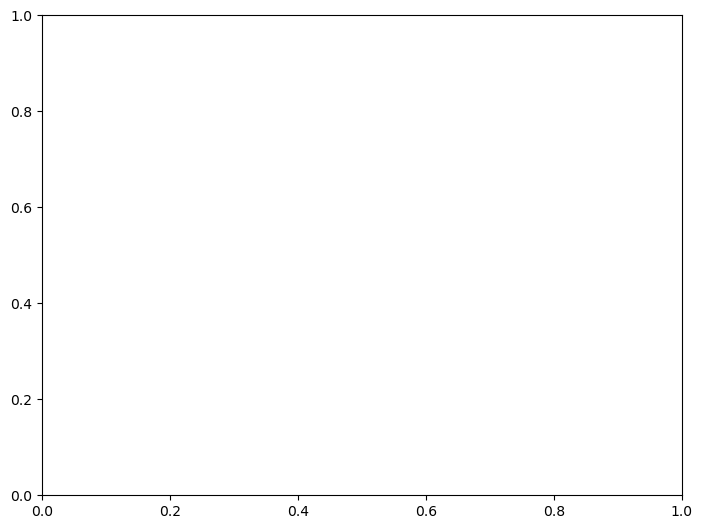

In [4]:
create_pngs_from_wavs('datasets/Audio/Aptly_real/', 'datasets/Spectrograms/')

### Cleaning Label Filepaths

In [ ]:
df_labels = pd.DataFrame(pd.read_csv('datasets/Metadata/ModelFilePairs/model_file_pairs.csv'))

In [ ]:
df_labels = df_labels.drop_duplicates()

In [ ]:
df_labels['filename'] = df_labels['filename'].str.rstrip('.wav')

In [ ]:
df_labels['filename'] = df_labels['filename'].str.rstrip('.mp3')

In [ ]:
df_labels['filename'] = df_labels['filename']

In [ ]:
df_labels['filename']

### Converting Spectrograms to Arrays & Labelling

The label of '0' corresponds to human speech, '1' corresponds to synthetic

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        if not file.endswith('.DS_Store'):  # exclude hidden macOS files
            img = tf.keras.preprocessing.image.load_img(os.path.join(path, file), target_size=(224, 224))
            img_array = np.array(img)
            images.append(img_array)
            labels.append((label))
        
    return images, labels

The dataset is large enough to reduce in size. We'll random sample only a portion of the data, making sure to maintain the 66% majority class.

In [6]:
human_path = 'datasets/Spectrograms/HUMAN/'
synthetic_path = 'datasets/Spectrograms/SYNTHETIC/'

human_images, human_labels = load_images_from_path(human_path, 0)
synthetic_images, synthetic_labels = load_images_from_path(synthetic_path, 1)

# randomly sample X % of the data, maintaining 67% of the human images and 33% of the synthetic images
human_sample_size = int(len(human_images) * 0.3)
synthetic_sample_size = int(len(synthetic_images) * 0.2)

human_sampled_indices = random.sample(range(len(human_images)), human_sample_size)
human_sampled_images = [human_images[i] for i in human_sampled_indices]
human_sampled_labels = [0] * human_sample_size

synthetic_sampled_indices = random.sample(range(len(synthetic_images)), synthetic_sample_size)
synthetic_sampled_images = [synthetic_images[i] for i in synthetic_sampled_indices]
synthetic_sampled_labels = [1] * synthetic_sample_size

x = human_sampled_images + synthetic_sampled_images
y = human_sampled_labels + synthetic_sampled_labels

X = np.array(x)
Y = np.array(y).reshape(-1, 1)

In [7]:
print("X :", X.shape)
print("Y:", Y.shape)

X : (36301, 224, 224, 3)
Y: (36301, 1)


In [8]:
X, Y

(array([[[[  7,   5,  28],
          [  0,   0,   3],
          [  0,   0,   3],
          ...,
          [  0,   0,   3],
          [  0,   0,   3],
          [  0,   0,   3]],
 
         [[  8,   6,  30],
          [  0,   0,   4],
          [  0,   0,   4],
          ...,
          [  0,   0,   4],
          [  0,   0,   4],
          [  0,   0,   4]],
 
         [[  8,   6,  30],
          [  0,   0,   4],
          [  0,   0,   4],
          ...,
          [  0,   0,   4],
          [  0,   0,   4],
          [  0,   0,   4]],
 
         ...,
 
         [[218,  77,  93],
          [223,  74, 104],
          [211,  67, 110],
          ...,
          [124,  35, 130],
          [161,  48, 126],
          [188,  57, 120]],
 
         [[188,  57, 108],
          [189,  57, 119],
          [207,  64, 112],
          ...,
          [194,  59, 117],
          [179,  54, 122],
          [200,  62, 115]],
 
         [[188,  57, 108],
          [189,  57, 119],
          [207,  64, 112],
   

### Pickles

In [11]:
with open('pickles/X.pkl', 'wb') as f:
    pickle.dump(X, f)

In [12]:
with open('pickles/Y.pkl', 'wb') as f:
    pickle.dump(Y, f)